
# Chapter 10 Lab: Deep Learning

In this section, we show how to fit the examples discussed in the text. We use the `keras` package, which interfaces to the
`tensorflow` package which in turn links to efficient
`python` code. This code is
impressively fast, and the package is well-structured. A good companion
is the text **Deep Learning with R**
(F. Chollet and
  J.J. Allaire, \emph{Deep Learning with R}
  (2018), Manning Publications,) and most of our code is adapted from
there.

Getting `keras` up and running on your computer can be a
challenge.  The book website [www.statlearning.com](www.statlearning.com) gives
step-by-step instructions on how to achieve this.
(Many thanks to Balasubramanian Narasimhan for preparing the `keras`
installation instructions.)
Guidance can also be found at [keras.rstudio.com](keras.rstudio.com))

Instead of installing conda, keras, and tensorflow on your local machine, we will be working in Google Colaboratory (Colab), Google's cloud-based colaborative notebook. You should be able to access it by going to: https://colab.to/r -- and, if you are logged into your CU Google account, it should link to it.

If Colab doesn't work for you, you can use 
- Kaggle (https://www.kaggle.com/code/scratchpad/notebookfe034579b3/edit)
- RStudio Cloud (https://rstudio.cloud/)
- Binder (https://mybinder.org/)
- AWS (https://aws.amazon.com/free/free-tier-faqs/)

They all offer free cloud accounts with R and Python kernels.

## Single Layer Network on Hitters Data

We start by fitting the models in Section 10.6.
We set up the data, and separate out a training and
test set.

In [ ]:
install.packages("ISLR2") # you only need to do this once per session
library(ISLR2)
Gitters <- na.omit(Hitters)
n <- nrow(Gitters)
set.seed(13)
ntest <- trunc(n / 3)
testid <- sample(1:n, ntest)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



The linear model should be familiar, but we present it anyway.

In [ ]:
lfit <- lm(Salary ~ ., data = Gitters[-testid, ])
lpred <- predict(lfit, Gitters[testid, ])
with(Gitters[testid, ], mean(abs(lpred - Salary)))

[1] 254.6687

Notice the use of the `with()` command: the first argument is a
dataframe, and the second an expression that can refer to elements of
the dataframe by name. In this instance the dataframe corresponds to
the test data and the expression computes the mean absolute prediction
error on this data.

Next we fit the lasso using `glmnet`. Since this package does
not use formulas, we create `x` and `y` first.

In [ ]:
x <- scale(model.matrix(Salary ~ . - 1, data = Gitters))
y <- Gitters$Salary

The first line makes a call
to `model.matrix()`,  which produces the same matrix that was
used by `lm()` (the `-1`  omits the intercept).
This function automatically converts factors to dummy variables.
The `scale()` function standardizes the matrix so each column
has mean zero and variance one.

In [ ]:
install.packages("glmnet")
library(glmnet)
cvfit <- cv.glmnet(x[-testid, ], y[-testid],
    type.measure = "mae")
cpred <- predict(cvfit, x[testid, ], s = "lambda.min")
mean(abs(y[testid] - cpred))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘RcppEigen’


Loading required package: Matrix

Loaded glmnet 4.1-4



[1] 252.2994

To fit the neural network, we first set up a model structure
that describes the network.

In [1]:
install.packages("keras")
library(keras)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’




In [ ]:
modnn <- keras_model_sequential() %>%
     layer_dense(units = 50, activation = "relu",
        input_shape = ncol(x)) %>%
     layer_dropout(rate = 0.4) %>%
     layer_dense(units = 1)

Loaded Tensorflow version 2.9.2



We have created a vanilla model
object called `modnn`, and have added details about the successive
layers in a sequential manner, using the function `keras_model_sequential()`.
The `pipe` operator `%>%`
 passes the previous term as the first argument to the next
function, and returns the result.
It allows us to specify the layers of
a neural network in a readable form.

We illustrate the use of the pipe operator on a simple example. Earlier, we created `x` using the command

In [ ]:
x <- scale(model.matrix(Salary ~ . - 1, data = Gitters))

We first make a matrix, and then we center each of the variables.
Compound expressions like this can be difficult to parse. We could have obtained the same result using the pipe operator:

In [ ]:
x <- model.matrix(Salary ~ . - 1, data = Gitters) %>% scale()

Using the pipe operator makes it easier to follow the sequence of operations.

We now return to our neural network. The object `modnn` has a single hidden layer with 50 hidden units, and
a ReLU activation function. It then has a dropout layer, in which a
random 40% of the 50 activations from the previous layer are set to zero
during each iteration of the stochastic gradient descent
algorithm. Finally, the output layer has just one unit with no
activation function, indicating that the model provides a single
quantitative output.

Next we add details to  `modnn` that control the fitting
algorithm. Here we have simply followed the examples given in
the Keras book. We minimize squared-error loss as in
(10.22). The algorithm
tracks the mean absolute error on the training data, and
on validation data if it is supplied.

In [ ]:
modnn %>% compile(loss = "mse",
    optimizer = optimizer_rmsprop(),
    metrics = list("mean_absolute_error")
   )

In the previous line, the pipe operator passes `modnn` as the first argument to `compile()`. The `compile()` function does not actually change the `R`
object `modnn`, but it does communicate these specifications to
the corresponding `python` instance of this model that has been created
along the way.

Now we fit the model. We supply the training data and  two
fitting parameters, `epochs` and `batch_size`. Using 32
for the latter means that at each step of SGD, the algorithm randomly
selects 32 training observations for the computation of the gradient. Recall from
Sections 10.4 and 10.7
that an epoch amounts to the number of SGD steps required to process $n$
observations. Since the training set has
$n=176$, an epoch is $176/32=5.5$ SGD steps. The `fit()` function has an argument
`validation_data`; these data are not used in the fitting,
but can be used to track the progress of the model (in this case reporting
mean absolute error). Here we
actually supply the test data so we can see mean absolute error of both the
training data and test data as the epochs proceed. To see more options
for fitting, use `?fit.keras.engine.training.Model`.

In [ ]:
history <- modnn %>% fit(
#    x[-testid, ], y[-testid], epochs = 1500, batch_size = 32,
     x[-testid, ], y[-testid], epochs = 300, batch_size = 32,
    validation_data = list(x[testid, ], y[testid])
  )

*(Here and elsewhere we have reduced the number of epochs to make
    runtimes manageable; users can of course change back)*

We can plot the `history` to display the mean absolute error for the training and test data. For the best aesthetics, install the `ggplot2` package before calling the  `plot()` function. If you have not installed `ggplot2`, then the code below will still run, but the plot will be less attractive.

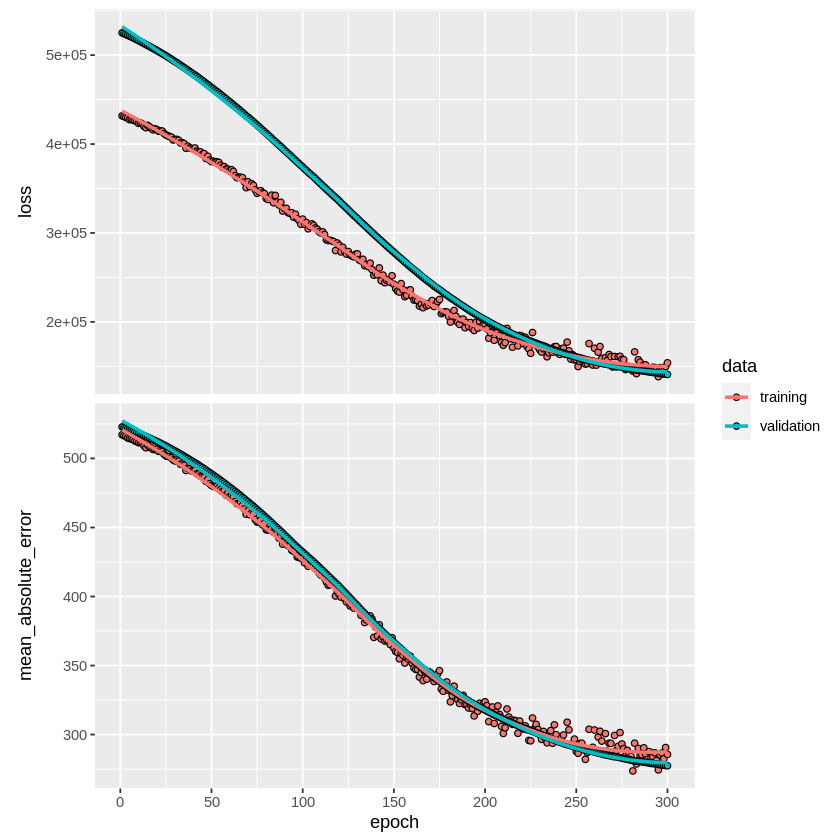

In [ ]:
plot(history)

It is worth noting that if you run the `fit()` command a second time in the same `R` session, then the fitting process will pick up where it left off. Try re-running the `fit()` command, and then the `plot()` command, to see!

Finally, we predict from the final model, and
evaluate its performance on the test data. Due to the use of SGD, the results vary slightly with each
fit. Unfortunately the `set.seed()` function does not ensure
identical results (since the fitting is done in `python`), so your results will differ slightly.

In [ ]:
npred <- predict(modnn, x[testid, ])
mean(abs(y[testid] - npred))

[1] 277.4137

## Multilayer Network on the MNIST Digit Data

The `keras` package comes with a number of example datasets,
including the `MNIST` digit data. Our first step is to load the
`MNIST` data. The `dataset_mnist()` function is provided for this purpose.

In [ ]:
mnist <- dataset_mnist()
x_train <- mnist$train$x
g_train <- mnist$train$y
x_test <- mnist$test$x
g_test <- mnist$test$y
dim(x_train)
dim(x_test)

[1] 60000    28    28

[1] 10000    28    28

There are 60,000 images in the training data and 10,000 in the test data. The images are $28\times 28$, and stored as a three-dimensional array,
so we need to reshape them into a matrix.  Also, we need to ``one-hot''
encode the class label. Luckily `keras` has a lot of built-in
functions that do this for us.

In [ ]:
x_train <- array_reshape(x_train, c(nrow(x_train), 784))
x_test <- array_reshape(x_test, c(nrow(x_test), 784))
y_train <- to_categorical(g_train, 10)
y_test <- to_categorical(g_test, 10)

Neural networks are somewhat sensitive to the scale of the inputs. For example, ridge and
lasso regularization are affected by scaling.  Here the inputs are eight-bit
(Note: Eight bits means $2^8$, which equals 256. Since the convention
is to start at $0$, the possible values  range from $0$ to $255$.)
grayscale values between 0 and 255, so we rescale to the unit
interval.

In [ ]:
x_train <- x_train / 255
x_test <- x_test / 255

Now we are ready to fit our neural network.

In [ ]:
modelnn <- keras_model_sequential()
modelnn %>%
   layer_dense(units = 256, activation = "relu",
       input_shape = c(784)) %>%
   layer_dropout(rate = 0.4) %>%
   layer_dense(units = 128, activation = "relu") %>%
   layer_dropout(rate = 0.3) %>%
   layer_dense(units = 10, activation = "softmax")

The first layer goes from  $28\times28=784$ input units to a hidden
layer of $256$ units, which uses the ReLU activation function.
This is specified by a call to `layer\_dense()`, which takes as
input a `modelnn` object, and returns a modified `modelnn`
object.
This is then piped through `layer\_dropout()` to perform
dropout regularization. The second hidden layer comes
next, with $128$ hidden units, followed by a  dropout layer.
The final layer is the output layer, with activation
`"softmax"` (10.12) for the 10-class classification
problem, which defines the map from the second hidden layer to class
probabilities.
Finally, we use `summary()` to summarize the model, and to make sure we got it
all right.

In [ ]:
summary(modelnn)

Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_4 (Dense)                    (None, 256)                     200960      
 dropout_2 (Dropout)                (None, 256)                     0           
 dense_3 (Dense)                    (None, 128)                     32896       
 dropout_1 (Dropout)                (None, 128)                     0           
 dense_2 (Dense)                    (None, 10)                      1290        
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
________________________________________________________________________________


The parameters for each layer include a bias term, which results in a
parameter count of 235,146. For example, the first hidden
layer involves $(784+1)\times 256=200{,}960$ parameters.

Notice that the layer names such as `dropout_1` and
`dense_2` have subscripts. These may appear somewhat random; in
fact, if you fit the same model again, these will change. They are of
no consequence: they vary because the model
specification code is run in `python`, and these subscripts are incremented every time
`keras_model_sequential()` is called.

Next, we add details to the model to specify the fitting algorithm. We fit the model by minimizing the cross-entropy function given by (10.13).

In [ ]:
modelnn %>% compile(loss = "categorical_crossentropy",
    optimizer = optimizer_rmsprop(), metrics = c("accuracy")
  )

Now we are ready to go. The final step is to supply training data, and fit the model.

   user  system elapsed 
 51.507   3.564  34.425 

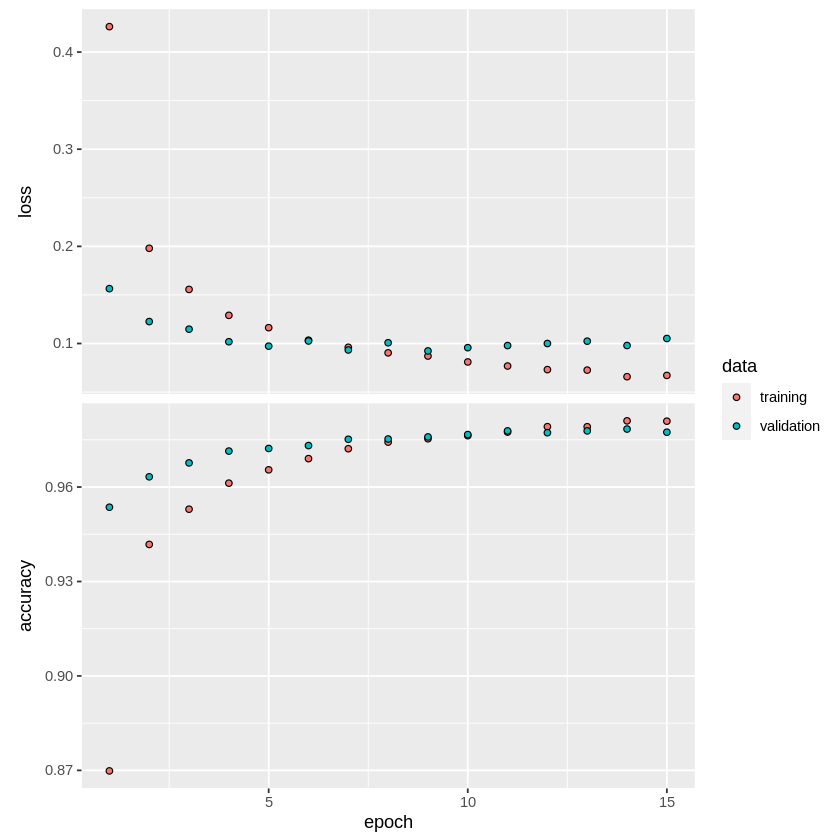

In [ ]:
system.time(
   history <- modelnn %>%
#     fit(x_train, y_train, epochs = 30, batch_size = 128,
      fit(x_train, y_train, epochs = 15, batch_size = 128,
        validation_split = 0.2)
 )
plot(history, smooth = FALSE)

We have suppressed the output here, which is a progress report on the
fitting of the model, grouped by epoch. This is very useful, since on
large datasets fitting can take time. Fitting this model took 144
seconds on a 2.9GHz MacBook Pro with 4 cores and 32 GB of RAM.
Here we specified a
validation split of 20%, so the training is actually performed on
80% of the 60,000 observations in the training set. This is an
alternative to actually supplying validation data, like we did in
Section 10.9.1. See
`?fit.keras.engine.training.Model` for all the optional fitting arguments. SGD  uses batches
of 128 observations in computing the gradient, and doing the
arithmetic, we see that an epoch corresponds to 375 gradient steps.
The last `plot()` command produces a figure similar to Figure 10.18.

To obtain the test error in Table 10.1, we first write
a simple function `accuracy()` that compares predicted and true
class labels, and then use it to evaluate our predictions.

In [ ]:
accuracy <- function(pred, truth) {
   mean(drop(as.numeric(pred)) == drop(truth)) }
modelnn %>% predict(x_test) %>% k_argmax() %>% accuracy(g_test)

[1] 0.9788

The table also reports LDA (Chapter 4) and multiclass logistic
regression. Although packages such as `glmnet` can handle
multiclass logistic regression, they are quite slow on this large
dataset. It is much faster and quite easy to fit such a model
using the `keras` software. We just have an input layer and output layer, and omit the hidden layers!

In [ ]:
modellr <- keras_model_sequential() %>%
   layer_dense(input_shape = 784, units = 10,
       activation = "softmax")
summary(modellr)

Model: "sequential_2"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_5 (Dense)                    (None, 10)                      7850        
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
________________________________________________________________________________


We fit the model just as before.

In [ ]:
modellr %>% compile(loss = "categorical_crossentropy",
     optimizer = optimizer_rmsprop(), metrics = c("accuracy"))
modellr %>% fit(x_train, y_train, epochs = 30,
      batch_size = 128, validation_split = 0.2)
modellr %>% predict(x_test) %>% k_argmax() %>% accuracy(g_test)

[1] 0.9287

[link text](https://)### Convolutional Neural Networks

In this section we fit a CNN to the `CIFAR` data, which is available in the `keras`
package. It is arranged in a similar fashion as the `MNIST` data.

In [2]:
cifar100 <- dataset_cifar100()
names(cifar100)
x_train <- cifar100$train$x
g_train <- cifar100$train$y
x_test <- cifar100$test$x
g_test <- cifar100$test$y
dim(x_train)
range(x_train[1,,, 1])

Loaded Tensorflow version 2.9.2



[1] "train" "test"

[1] 50000    32    32     3

[1]  13 255

The array of 50,000 training images has four dimensions:
  each three-color image is represented as a set of three channels, each of which consists of
$32\times 32$ eight-bit pixels. We standardize as we did for the
digits, but keep the array structure. We one-hot encode the response
factors  to produce a 100-column binary matrix.

In [3]:
x_train <- x_train / 255
x_test <- x_test / 255
y_train <- to_categorical(g_train, 100)
dim(y_train)

[1] 50000   100

Before we start, we look at some of the training images using  the `jpeg` package; similar code produced
Figure 10.5 on page 411.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



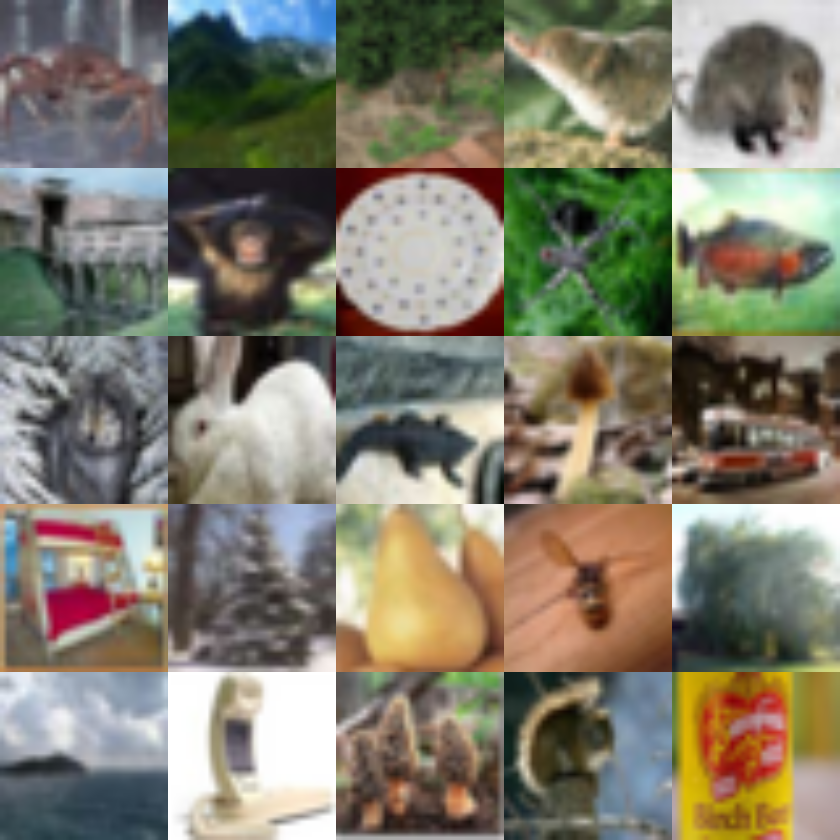

In [4]:
install.packages("jpeg")
library(jpeg)
par(mar = c(0, 0, 0, 0), mfrow = c(5, 5))
index <- sample(seq(50000), 25)
for (i in index) plot(as.raster(x_train[i,,, ]))

The `as.raster()` function converts the feature map so that it can be plotted as a color image.

Here we specify a moderately-sized  CNN for
demonstration purposes, similar in structure to Figure 10.8.

In [ ]:
model <- keras_model_sequential() %>%
   layer_conv_2d(filters = 32, kernel_size = c(3, 3),
      padding = "same", activation = "relu",
      input_shape = c(32, 32, 3)) %>%
   layer_max_pooling_2d(pool_size = c(2, 2)) %>%
   layer_conv_2d(filters = 64, kernel_size = c(3, 3),
      padding = "same", activation = "relu") %>%
   layer_max_pooling_2d(pool_size = c(2, 2)) %>%
   layer_conv_2d(filters = 128, kernel_size = c(3, 3),
      padding = "same", activation = "relu") %>%
   layer_max_pooling_2d(pool_size = c(2, 2)) %>%
   layer_conv_2d(filters = 256, kernel_size = c(3, 3),
      padding = "same", activation = "relu") %>%
   layer_max_pooling_2d(pool_size = c(2, 2)) %>%
   layer_flatten() %>%
   layer_dropout(rate = 0.5) %>%
   layer_dense(units = 512, activation = "relu") %>%
   layer_dense(units = 100, activation = "softmax")
summary(model)

Model: "sequential_3"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_3 (Conv2D)                  (None, 32, 32, 32)              896         
 max_pooling2d_3 (MaxPooling2D)     (None, 16, 16, 32)              0           
 conv2d_2 (Conv2D)                  (None, 16, 16, 64)              18496       
 max_pooling2d_2 (MaxPooling2D)     (None, 8, 8, 64)                0           
 conv2d_1 (Conv2D)                  (None, 8, 8, 128)               73856       
 max_pooling2d_1 (MaxPooling2D)     (None, 4, 4, 128)               0           
 conv2d (Conv2D)                    (None, 4, 4, 256)               295168      
 max_pooling2d (MaxPooling2D)       (None, 2, 2, 256)               0           
 flatten (Flatten)                  (None, 1024)                    0           
 dropout_3 (Dropout)                (None, 1024)                    0           
 dense

Notice that we used the `padding = "same"` argument to
`layer_conv_2D()`, which ensures that the output channels have the
same dimension as the input channels. There are 32 channels in the first
hidden layer, in contrast to the three channels in the input layer. We
use a $3\times 3$ convolution filter for each channel in all the layers. Each
convolution is followed by a max-pooling layer over $2\times2$
blocks. By studying the summary, we can see that the channels halve in both
dimensions
after each of these max-pooling operations. After the last of these we
have a layer with  256 channels of dimension $2\times 2$. These are then
flattened to a dense layer of size 1,024:
in other words, each of the $2\times 2$ matrices is turned into a
$4$-vector, and put side-by-side in one layer. This is followed by a
dropout regularization layer,  then
another dense layer of size 512, which finally reaches the softmax
output layer.

Finally, we specify the fitting algorithm, and fit the model.

In [ ]:
model %>% compile(loss = "categorical_crossentropy",
    optimizer = optimizer_rmsprop(), metrics = c("accuracy"))
#history <- model %>% fit(x_train, y_train, epochs = 30,
system.time(
  history <- model %>% fit(x_train, y_train, epochs = 1,
    batch_size = 128, validation_split = 0.2)
)
model %>% predict(x_test) %>% k_argmax() %>% accuracy(g_test)

   user  system elapsed 
209.664   4.050 111.576 

[1] 0.1288

This model takes 10 minutes to run and achieves 46% accuracy on the test
data. Although this is not terrible for 100-class data (a random
classifier gets 1% accuracy), searching the web we see results around
75%. Typically it takes a lot of architecture carpentry,
fiddling with regularization, and time to achieve such results.

## Using Pretrained CNN Models

We now show how to use a CNN pretrained on the  `imagenet` database to classify natural
images, and demonstrate how we produced Figure ???.
We copied six jpeg images from a digital photo album into the
directory `book_images`. (These images are available
  from the data section of  [www.statlearning.com](www.statlearning.com), the ISL book website. Download `book_images.zip`; when
clicked it creates the `book_images` directory.) We first read in the images, and
convert them into the array format expected by the `keras`
software to match the specifications in `imagenet`. Make sure that your working directory in `R` is set to the folder in which the images are stored.

In [ ]:
#img_dir <- "book_images"
#image_names <- list.files(img_dir)
#num_images <- length(image_names)
#x <- array(dim = c(num_images, 224, 224, 3))
#for (i in 1:num_images) {
#   img_path <- paste(img_dir, image_names[i], sep = "/")
#   img <- image_load(img_path, target_size = c(224, 224))
#   x[i,,, ] <- image_to_array(img)
#}
#
#x <- imagenet_preprocess_input(x)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bmp’, ‘tiff’, ‘readbitmap’, ‘downloader’, ‘igraph’


Loading required package: magrittr


Attaching package: ‘imager’


The following object is masked from ‘package:magrittr’:

    add


The following objects are masked from ‘package:stats’:

    convolve, spectrum


The following object is masked from ‘package:graphics’:

    frame


The following object is masked from ‘package:base’:

    save.image




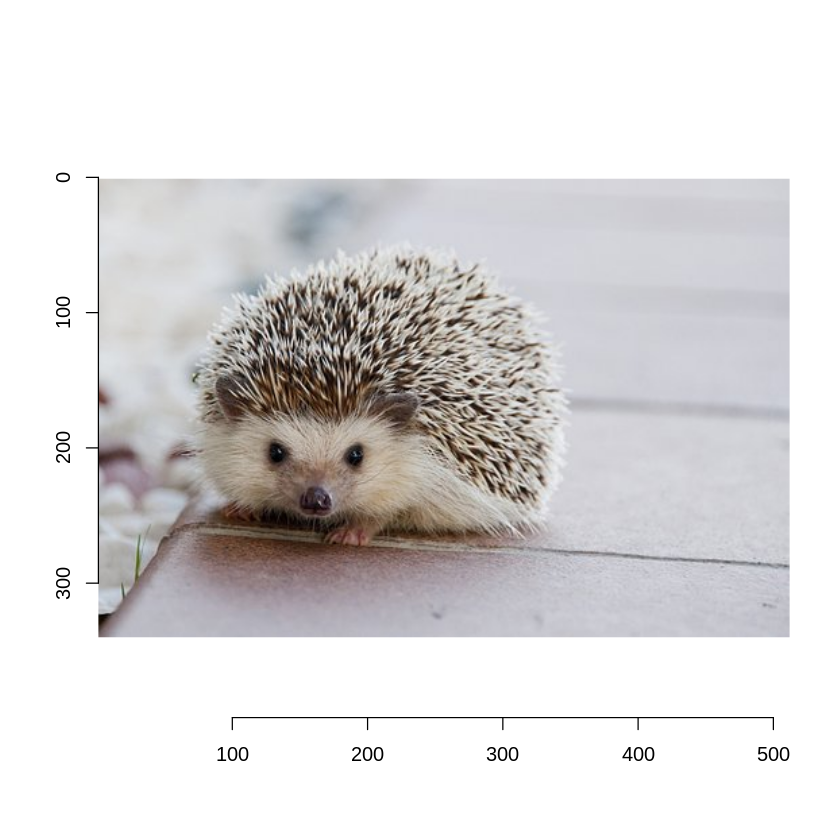

In [5]:
# alternatively, download images from the web
install.packages("imager")
library(imager)
img <- load.image("https://cdn.pixabay.com/photo/2016/02/22/10/06/hedgehog-1215140__340.jpg") %>% plot
save.image(img, "hhog.jpg")


We then load the trained network. The model has 50 layers, with a fair bit of complexity.

In [ ]:
model <- application_resnet50(weights = "imagenet")
summary(model)

Model: "resnet50"
________________________________________________________________________________
 Layer (type)         Output Shape   Param #  Connected to           Trainable  
 input_1 (InputLayer)  [(None, 224,   0       []                     Y          
                      224, 3)]                                                  
 conv1_pad (ZeroPaddi  (None, 230, 2  0       ['input_1[0][0]']      Y          
 ng2D)                30, 3)                                                    
 conv1_conv (Conv2D)  (None, 112, 1  9472     ['conv1_pad[0][0]']    Y          
                      12, 64)                                                   
 conv1_bn (BatchNorma  (None, 112, 1  256     ['conv1_conv[0][0]']   Y          
 lization)            12, 64)                                                   
 conv1_relu (Activati  (None, 112, 1  0       ['conv1_bn[0][0]']     Y          
 on)                  12, 64)                                                   
 pool1_pad

In [6]:
img_path <-"hhog.jpg"
img <- image_load(img_path, target_size = c(224, 224))
x <- image_to_array(img)
x <- array_reshape(x, dim = c(1, 224, 224, 3))
x <- imagenet_preprocess_input(x)


Finally, we classify our six images, and return the top three class
choices in terms of predicted probability for each.

In [ ]:
pred6 <- model %>% predict(x) %>%
   imagenet_decode_predictions(top = 3)
#names(pred6) <- image_names
names(pred6) <- 'hedgehog'
print(pred6)

$hedgehog
  class_name class_description        score
1  n02346627         porcupine 0.9984720349
2  n02138441           meerkat 0.0009375354
3  n01872401           echidna 0.0001793917



## IMDb Document Classification

Now we perform document classification (Section ???) on the `IMDB` dataset, which is available as part of the `keras`
package. We  limit the dictionary size to the
10,000  most frequently-used words and tokens.

In [ ]:
max_features <- 10000
imdb <- dataset_imdb(num_words = max_features)
c(c(x_train, y_train), c(x_test, y_test)) %<-% imdb

The third line is a shortcut for unpacking the list of lists.
Each element of `x_train` is a vector of numbers between 0 and
9999 (the document), referring to the words found in the dictionary.
For example, the first training document is the positive review on
page  419. The indices of the first 12 words are given below.
\

In [ ]:
x_train[[1]][1:12]

[1]    1   14   22   16   43  530  973 1622 1385   65  458 4468

To see the words, we create a function, `decode_review()`, that provides a simple interface to the dictionary.

In [ ]:
word_index <- dataset_imdb_word_index()
decode_review <- function(text, word_index) {
   word <- names(word_index)
   idx <- unlist(word_index, use.names = FALSE)
   word <- c("<PAD>", "<START>", "<UNK>", "<UNUSED>", word)
   idx <- c(0:3, idx + 3)
   words <- word[match(text, idx, 2)]
   paste(words, collapse = " ")
}
decode_review(x_train[[1]][1:12], word_index)

[1] "<START> this film was just brilliant casting location scenery story direction everyone's"

Next we write a function to *one-hot* encode each document in a list
of documents, and return a binary matrix in sparse-matrix format.

In [ ]:
library(Matrix)
one_hot <- function(sequences, dimension) {
   seqlen <- sapply(sequences, length)
   n <- length(seqlen)
   rowind <- rep(1:n, seqlen)
   colind <- unlist(sequences)
   sparseMatrix(i = rowind, j = colind,
      dims = c(n, dimension))
}

To construct the sparse matrix, one supplies just the entries that are
nonzero. In the last line we call the function `sparseMatrix()` and supply the
row indices corresponding to each document and the column indices
corresponding to the words in each document, since we omit the
values they are taken to be all ones.
Words that appear more than once in any given document still get
recorded as a one.

In [ ]:
x_train_1h <- one_hot(x_train, 10000)
x_test_1h <- one_hot(x_test, 10000)
dim(x_train_1h)
nnzero(x_train_1h) / (25000 * 10000)

[1] 25000 10000

[1] 0.01316987

Only 1.3% of the entries are nonzero, so this amounts to considerable
savings in memory.
We create a validation set of size 2,000, leaving 23,000 for training.

In [ ]:
set.seed(3)
ival <- sample(seq(along = y_train), 2000)

First we fit a lasso logistic regression model using `glmnet()`
on the training data, and evaluate its performance on the validation
data. Finally, we plot the accuracy, `acclmv`, as a function of
the shrinkage parameter, $\lambda$. Similar expressions compute the
performance on the test data, and were used to produce the left plot
in Figure 10.11.

The code  takes advantage of the sparse-matrix format of
`x_train_1h`, and runs in about 5 seconds; in the usual
dense format it would take about 5 minutes.

In [ ]:
library(glmnet)
fitlm <- glmnet(x_train_1h[-ival, ], y_train[-ival],
    family = "binomial", standardize = FALSE)
classlmv <- predict(fitlm, x_train_1h[ival, ]) > 0
acclmv <- apply(classlmv, 2, accuracy,  y_train[ival] > 0)

as(<ngCMatrix>, "dgCMatrix") is deprecated since Matrix 1.5-0; do as(., "dMatrix") instead



We applied the `accuracy()` function that we wrote in Lab 10.9.2
to every column of the prediction matrix
`classlmv`, and since this is a logical matrix of  `TRUE/FALSE` values, we
supply the second argument `truth` as a logical vector as well.

Before making a plot, we adjust the plotting window.

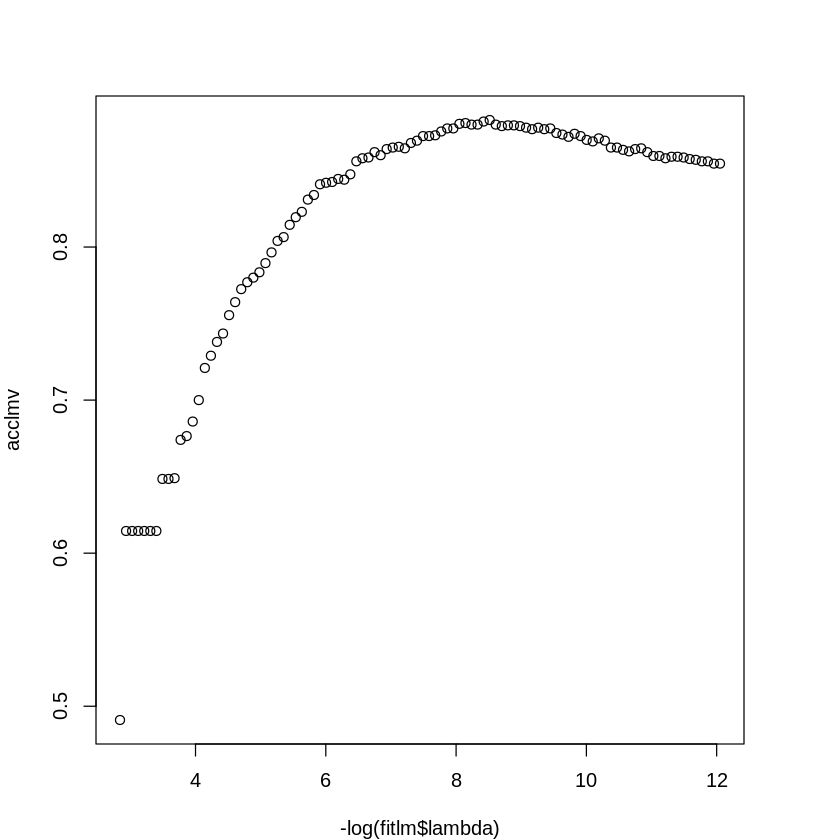

In [ ]:
par(mar = c(4, 4, 4, 4), mfrow = c(1, 1))
plot(-log(fitlm$lambda), acclmv)

Next we fit a fully-connected neural network with two hidden layers,
each with 16 units and ReLU activation.

In [ ]:
model <- keras_model_sequential() %>%
   layer_dense(units = 16, activation = "relu",
      input_shape = c(10000)) %>%
   layer_dense(units = 16, activation = "relu") %>%
   layer_dense(units = 1, activation = "sigmoid")
model %>% compile(optimizer = "rmsprop",
   loss = "binary_crossentropy", metrics = c("accuracy"))
history <- model %>% fit(x_train_1h[-ival, ], y_train[-ival],
   epochs = 20, batch_size = 512,
   validation_data = list(x_train_1h[ival, ], y_train[ival]))
    

The `history` object has a `metrics` component that
records both the training and validation accuracy at each epoch.
Figure ??? includes test accuracy at each epoch as well. To
compute the test accuracy, we
rerun the entire sequence above, replacing the last line with

In [ ]:
model <- keras_model_sequential() %>%
   layer_dense(units = 16, activation = "relu",
      input_shape = c(10000)) %>%
   layer_dense(units = 16, activation = "relu") %>%
   layer_dense(units = 1, activation = "sigmoid")
model %>% compile(optimizer = "rmsprop",
   loss = "binary_crossentropy", metrics = c("accuracy"))
   history <- model %>% fit(
    x_train_1h[-ival, ], y_train[-ival], epochs = 20,
    batch_size = 512, validation_data = list(x_test_1h, y_test)
    )


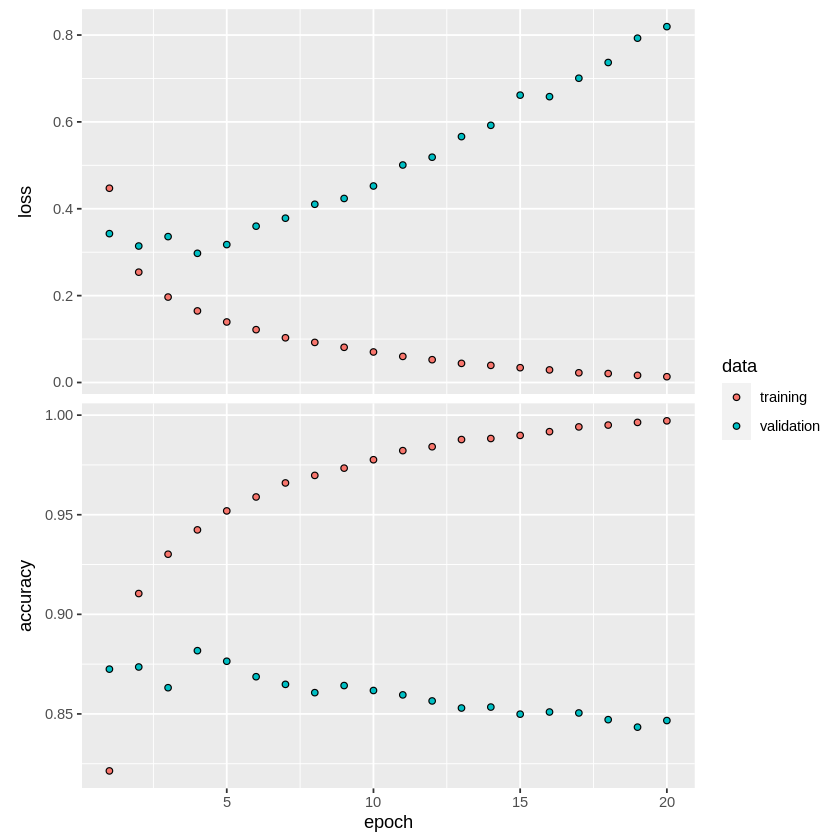

In [ ]:
plot(history, smooth = FALSE)

## Recurrent Neural Networks

In this lab we fit the models illustrated in
Section 10.5.

### Sequential Models for Document Classification

Here we  fit a simple  LSTM RNN for sentiment analysis with
the `IMDB` movie-review data, as discussed in Section 10.5.1. We showed how to input the data in
10.9.5, so we will not repeat that here.

We first calculate the lengths of the documents.


In [ ]:
wc <- sapply(x_train, length)
median(wc)
sum(wc <= 500) / length(wc)

[1] 178

[1] 0.91568

We see that over 91% of the documents have fewer than 500 words. Our
RNN requires all the document sequences to have the same length. We hence
restrict the document lengths to the last $L=500$ words, and pad the
beginning of the
shorter ones with blanks.

In [ ]:
maxlen <- 500
x_train <- pad_sequences(x_train, maxlen = maxlen)
x_test <- pad_sequences(x_test, maxlen = maxlen)
dim(x_train)
dim(x_test)
x_train[1, 490:500]

[1] 25000   500

[1] 25000   500

[1]   16 4472  113  103   32   15   16 5345   19  178   32

The last expression shows the last few words in the first document. At this stage, each of the 500 words in the document  is represented using an integer
corresponding to the location of that word in the 10,000-word dictionary.
The first layer of the RNN is an embedding layer of size 32, which will be
learned during  training. This layer one-hot encodes  each document
as a matrix of dimension $500 \times 10,000$, and then maps these
$10,000$ dimensions down to $32$.

In [ ]:
model <- keras_model_sequential() %>%
   layer_embedding(input_dim = 10000, output_dim = 32) %>%
   layer_lstm(units = 32) %>%
   layer_dense(units = 1, activation = "sigmoid")

The second  layer is an LSTM with 32 units, and the output
layer is a single sigmoid for the binary classification task.

The rest is now similar to other networks we have fit. We
track the test performance as the network is fit, and see that it attains 87\% accuracy.

[1] 0.8704

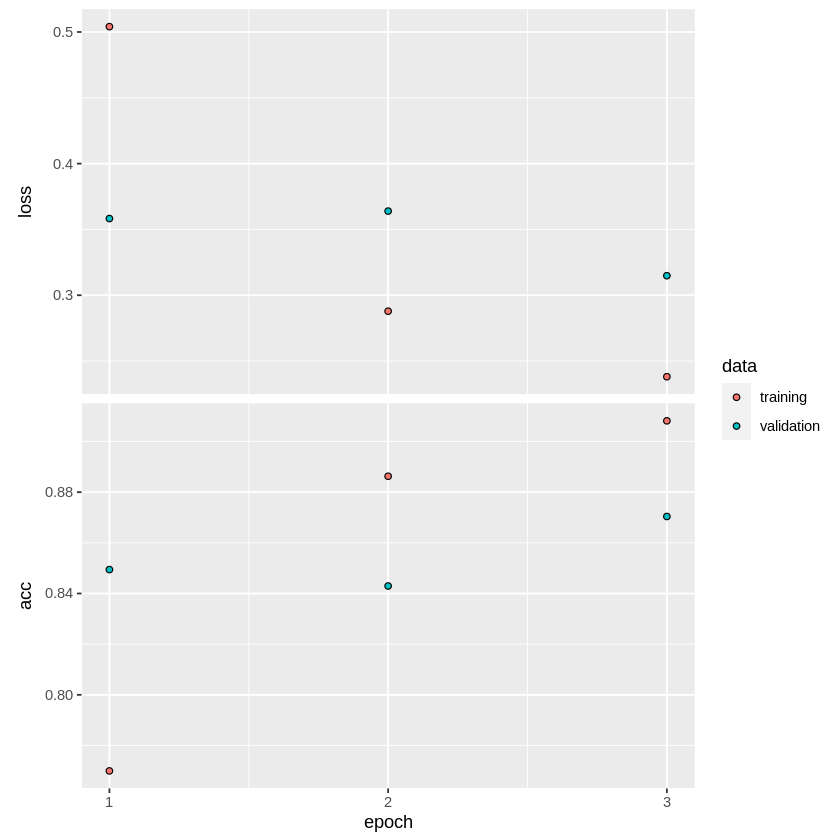

In [ ]:
model %>% compile(optimizer = "rmsprop",
    loss = "binary_crossentropy", metrics = c("acc"))
#history <- model %>% fit(x_train, y_train, epochs = 10,
history <- model %>% fit(x_train, y_train, epochs = 3,
    batch_size = 128, validation_data = list(x_test, y_test))
plot(history)
predy <- predict(model, x_test) > 0.5
mean(abs(y_test == as.numeric(predy)))

###  Time Series Prediction

We now show how to fit the models in Section ???
for  time series prediction.
We first set up the data, and standardize each of the variables.

In [ ]:
library(ISLR2)
xdata <- data.matrix(
 NYSE[, c("DJ_return", "log_volume","log_volatility")]
 )
istrain <- NYSE[, "train"]
xdata <- scale(xdata)

The  variable `istrain` contains a `TRUE` for each year that  is in the training set, and a `FALSE` for each year
 in the test set.

We first write functions to create lagged versions of the three time series.  We start with a function that takes as input a data
matrix and a lag $L$, and returns a lagged version of the matrix. It
simply inserts $L$ rows of `NA` at the top, and truncates the
bottom.

In [ ]:
lagm <- function(x, k = 1) {
   n <- nrow(x)
   pad <- matrix(NA, k, ncol(x))
   rbind(pad, x[1:(n - k), ])
}

We now use this function to create a data frame with all the required
lags, as well as the response variable.

In [ ]:
arframe <- data.frame(log_volume = xdata[, "log_volume"],
   L1 = lagm(xdata, 1), L2 = lagm(xdata, 2),
   L3 = lagm(xdata, 3), L4 = lagm(xdata, 4),
   L5 = lagm(xdata, 5)
 )

If we look at the first five rows of this frame, we will see some
missing values in the lagged variables (due to the construction above). We remove these rows, and adjust `istrain`
accordingly.

In [ ]:
arframe <- arframe[-(1:5), ]
istrain <- istrain[-(1:5)]

We now fit the linear AR model to the training data using `lm()`, and predict on the
test data.

In [ ]:
arfit <- lm(log_volume ~ ., data = arframe[istrain, ])
arpred <- predict(arfit, arframe[!istrain, ])
V0 <- var(arframe[!istrain, "log_volume"])
1 - mean((arpred - arframe[!istrain, "log_volume"])^2) / V0

[1] 0.413223

The last two lines compute the $R^2$ on the test data, as defined in (3.17).

We refit this model, including the factor variable `day_of_week`.

In [ ]:
arframed <-
    data.frame(day = NYSE[-(1:5), "day_of_week"], arframe)
arfitd <- lm(log_volume ~ ., data = arframed[istrain, ])
arpredd <- predict(arfitd, arframed[!istrain, ])
1 - mean((arpredd - arframe[!istrain, "log_volume"])^2) / V0

[1] 0.4598616

To fit the RNN, we need to reshape these data, since it expects a
sequence of $L=5$ feature vectors $X=\{X_\ell\}_1^L$ for each observation, as in (10.20) on
page  428. These are  lagged versions of the
time series going back $L$ time points.

In [ ]:
n <- nrow(arframe)
xrnn <- data.matrix(arframe[, -1])
xrnn <- array(xrnn, c(n, 3, 5))
xrnn <- xrnn[,, 5:1]
xrnn <- aperm(xrnn, c(1, 3, 2))
dim(xrnn)

[1] 6046    5    3

We have done this in four steps. The first simply extracts the
$n\times 15$ matrix of lagged versions of the three predictor
variables from `arframe`. The second converts this matrix to a
$n\times 3\times 5$ array. We can do this by simply changing the
dimension attribute, since the new array is filled column wise. The
third step reverses the order of lagged variables, so that index $1$
is furthest back in time, and index $5$ closest. The
final step rearranges the coordinates of the array (like a partial
transpose) into the format that the RNN module in `keras`
expects.

Now we are ready to proceed with the RNN, which uses 12 hidden units.

In [ ]:
model <- keras_model_sequential() %>%
   layer_simple_rnn(units = 12,
      input_shape = list(5, 3),
      dropout = 0.1, recurrent_dropout = 0.1) %>%
   layer_dense(units = 1)
model %>% compile(optimizer = optimizer_rmsprop(),
    loss = "mse")

We specify two forms of dropout for the units feeding into the  hidden
 layer. The first is for
the input sequence feeding into this layer, and the second is for the
previous hidden units feeding into the layer.
The output layer has a single unit for the response.

We  fit the model in a similar fashion to previous networks. We
supply the `fit` function with test data as validation data, so that when
we monitor its progress and plot the history function we can see the
progress on the test data. Of course we should not use this as a basis for
early stopping, since then the test performance would be biased.


In [ ]:
history <- model %>% fit(
    xrnn[istrain,, ], arframe[istrain, "log_volume"],
#    batch_size = 64, epochs = 200,
    batch_size = 64, epochs = 75,
    validation_data =
      list(xrnn[!istrain,, ], arframe[!istrain, "log_volume"])
  )
kpred <- predict(model, xrnn[!istrain,, ])
1 - mean((kpred - arframe[!istrain, "log_volume"])^2) / V0

[1] 0.4033576

This model takes about one minute to train.

We could replace the  `keras_model_sequential()`  command above with the following command:

In [ ]:
model <- keras_model_sequential() %>%
   layer_flatten(input_shape = c(5, 3)) %>%
   layer_dense(units = 1)

Here, `layer_flatten()` simply takes the input sequence and
turns it into a long vector of predictors. This results in a linear AR model.
To fit a nonlinear AR model, we could add in a hidden layer.

However, since we already have the matrix of lagged variables from the AR
model that we fit earlier using the `lm()` command, we can actually fit a nonlinear AR model without needing to perform flattening.
We extract the model matrix `x` from `arframed`, which
includes the `day_of_week` variable.

In [ ]:
x <- model.matrix(log_volume ~ . - 1, data = arframed)
colnames(x)

[1] "dayfri"            "daymon"            "daythur"          
 [4] "daytues"           "daywed"            "L1.DJ_return"     
 [7] "L1.log_volume"     "L1.log_volatility" "L2.DJ_return"     
[10] "L2.log_volume"     "L2.log_volatility" "L3.DJ_return"     
[13] "L3.log_volume"     "L3.log_volatility" "L4.DJ_return"     
[16] "L4.log_volume"     "L4.log_volatility" "L5.DJ_return"     
[19] "L5.log_volume"     "L5.log_volatility"

The `-1` in the formula avoids the creation of a column of ones for
the intercept. The variable `day\_of\_week` is a five-level
factor (there are five trading days), and the
 `-1` results in  five rather than four dummy variables.

The rest of the steps to fit a nonlinear AR model should by now be familiar.

[1] 0.4659797

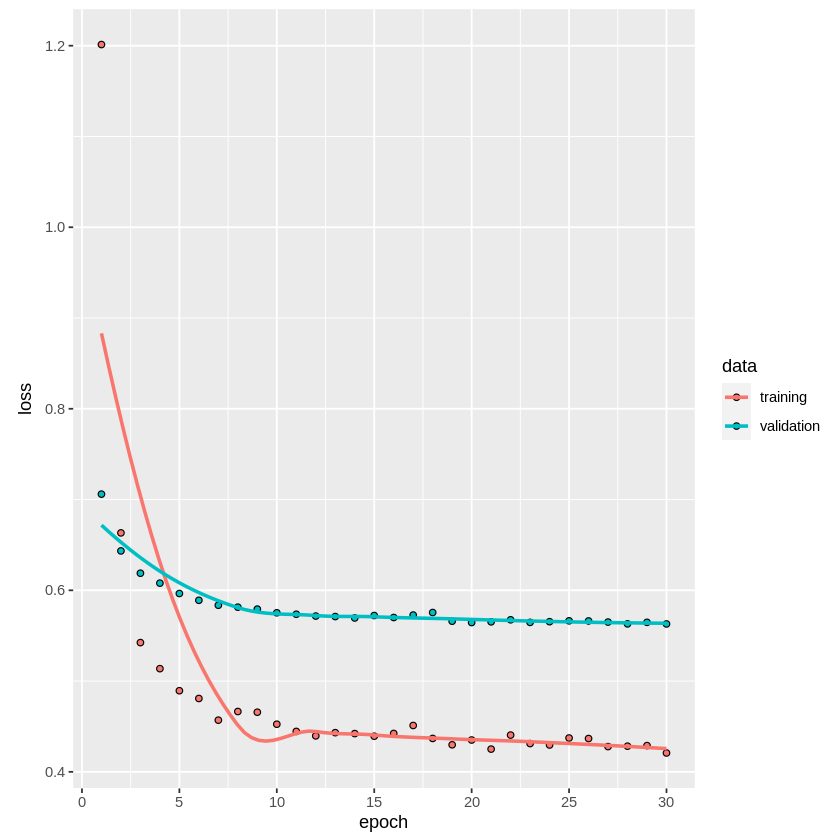

In [ ]:
arnnd <- keras_model_sequential() %>%
   layer_dense(units = 32, activation = 'relu',
      input_shape = ncol(x)) %>%
   layer_dropout(rate = 0.5) %>%
   layer_dense(units = 1)
arnnd %>% compile(loss = "mse",
    optimizer = optimizer_rmsprop())
history <- arnnd %>% fit(
#    x[istrain, ], arframe[istrain, "log_volume"], epochs = 100, 
    x[istrain, ], arframe[istrain, "log_volume"], epochs = 30, 
    batch_size = 32, validation_data =
      list(x[!istrain, ], arframe[!istrain, "log_volume"])
  )
plot(history)
npred <- predict(arnnd, x[!istrain, ])
1 - mean((arframe[!istrain, "log_volume"] - npred)^2) / V0